In [1]:
import numpy as np
import math

import albumentations as A
import cv2
from matplotlib import pyplot as plt
import os
import pandas as pd
import sys
import torch
import torchvision

from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms as T
from tqdm.notebook import tqdm
from typing import Callable, Iterable, List, Optional, Tuple, Union

In [2]:
sys.path.append('../src')

In [3]:
from omegaconf import ListConfig

from data.dataset import ExtendedWheatDataset, filter_by_source
from data.loader import fast_collate
from data.sampler import CustomSampler
from data.utils import basic_collate

In [4]:
DATA_DIR = Path('/media/dmitry/data/global-wheat-detection')

In [5]:
def cv2_imread(path: Union[str, Path]) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def read_bbox(bbox: str, bbox_format='pascal_voc') -> Tuple[int]:
    bb = map(float, bbox[1:-1].split(','))
    bb = list(map(int, bb))

    if len(bb) < 4:
        raise ValueError("Dumb bbox: {}".format(bbox))

    # 0 is a label
    if bbox_format == 'coco':
        bb = tuple(bb + [0])
    elif bbox_format == 'pascal_voc':
        x0, y0, w, h = bb
        bb = (x0, y0, x0 + w, y0 + h, 0)
    else:
        raise NotImplementedError(bbox_format)

    return bb


def bbox_str_to_numpy(bbox: str) -> np.ndarray:
    return np.array(read_bbox(bbox), dtype=np.uint16)

In [6]:
def draw_boxes(image: np.ndarray, bboxes: Iterable[np.ndarray]):
    for bb in bboxes:
        bb = bb[:4]
        assert len(bb) == 4
        if isinstance(bb, tuple):
            bb = tuple(map(int, bb))
        elif isinstance(bb, np.ndarray):
            bb = bb.astype(int)
        cv2.rectangle(image, tuple(bb[:2]), tuple(bb[2:]), (255, 0, 0), 1)

In [7]:
df = pd.read_csv(DATA_DIR/'train.csv')

In [8]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [9]:
df['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [10]:
df.loc[df['source'] == 'usask_1', 'image_id'].unique().shape

(200,)

In [11]:
# image_id = str(df.loc[0, 'image_id'])
image_id = str(df.iloc[0, 0])
path = DATA_DIR/'train'/(image_id + '.jpg')
print(path)

# Image.open(path)
# image = cv2_imread(str(path))

/media/dmitry/data/global-wheat-detection/train/b6ab77fd7.jpg


In [12]:
img_annots = df[df['image_id'] == image_id]
img_annots.head(3)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1


In [13]:
df['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [14]:
tfms = [
    A.Resize(512, 512, interpolation=cv2.INTER_AREA),
    A.Flip(p=0.75),
    A.RandomRotate90(p=0.75),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=(0.05, 0.15), rotate_limit=25, p=0.33),
    A.RandomBrightnessContrast(p=0.5),
    A.OneOf([
        A.RGBShift(r_shift_limit=20, b_shift_limit=20, g_shift_limit=20, p=1.0),
        A.HueSaturationValue(hue_shift_limit=15, val_shift_limit=10, p=1.0)
    ], p=0.5),
    A.OneOf([
        A.CLAHE(p=1.0),
        A.GaussianBlur(blur_limit=5, p=0.5),
        A.GaussNoise(p=1.0)
    ], p=0.5),
]

tfms = A.Compose(tfms, bbox_params=A.BboxParams('pascal_voc', min_visibility=0.05))

In [15]:
%%time

image_dir = DATA_DIR/'train'
csv_path = DATA_DIR/'train.csv'
gen_image_dirs = [DATA_DIR/'synthetic/2020-07-19/15-13-08']

ds = ExtendedWheatDataset(image_dir, csv_path, 
                          gen_image_dirs=gen_image_dirs, 
                          transforms=tfms, 
                          source=['inrae_1'])

Parsing bboxes...: 100%|██████████| 176/176 [00:00<00:00, 2089.13it/s]

CPU times: user 205 ms, sys: 19.8 ms, total: 225 ms
Wall time: 225 ms


In [16]:
len(ds), ds.num_orig_images

(1760, 176)

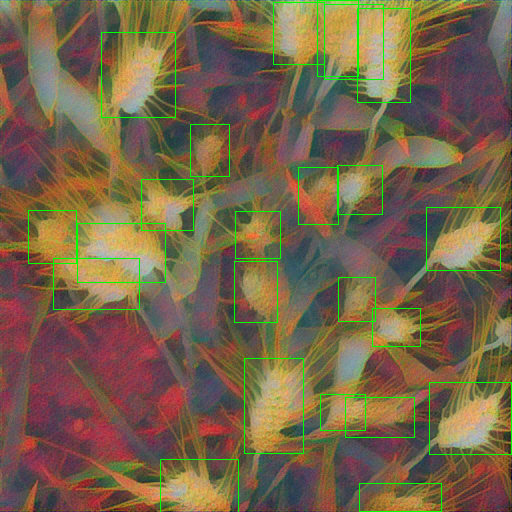

In [17]:
image, target = ds[450]
bboxes = target['bbox']

for bb in bboxes:
    p1 = tuple(bb[:2].astype(int))
    p2 = tuple(bb[2:].astype(int))
    cv2.rectangle(image, p1, p2, (0, 255, 0), 1)

Image.fromarray(image)

In [18]:
# from torch.utils.data.dataloader import default_collate

# def basic_collate(batch):
#     images, targets, gen = tuple(zip(*batch))
#     images = default_collate(images)
#     gen = default_collate(gen)
#     targets = list(map(default_collate, targets))
#     return images, targets, gen


dl = torch.utils.data.DataLoader(ds, 
                                 sampler=CustomSampler(ds, orig_images_ratio=0.2), 
                                 batch_size=8,
                                 collate_fn=fast_collate)

In [19]:
images, targets = next(iter(dl))

images.shape, len(targets)

(torch.Size([8, 512, 512, 3]), 4)